# Environment

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Dataset

In [2]:
DATASET_ROOT = './datasets/VPRC2023'
FEAT_TYPE = 'resnet18_baseline'
FEAT_OUTPUT_FOLDER = f"{DATASET_ROOT}_{FEAT_TYPE}"

### Load

In [3]:
X_train, y_train = [], []
X_test, y_test = [], []
train_folder = os.path.join(FEAT_OUTPUT_FOLDER, 'train')
test_folder = os.path.join(FEAT_OUTPUT_FOLDER, 'test')

class_map = {}  # maps product id to class index
id_map = {}  # maps class index to product id
for f in sorted(os.listdir(train_folder)):
    path = os.path.join(train_folder, f)
    feat = np.load(path)
    feat = feat / np.linalg.norm(feat)  # normalize
    X_train.append(feat[:, np.newaxis])

    label = int(f[0:4])
    if label not in class_map:
        class_map[label] = len(class_map)
        id_map[class_map[label]] = label
    y_train.append(class_map[label])
test_names = []
for f in sorted(os.listdir(test_folder)):
    test_names.append(os.path.splitext(f)[0][5:])
    path = os.path.join(test_folder, f)
    feat = np.load(path)
    feat = feat / np.linalg.norm(feat)  # normalize
    X_test.append(feat[:, np.newaxis])

    label = int(f[0:4])
    if label not in class_map:
        class_map[label] = len(class_map)
        id_map[class_map[label]] = label
    y_test.append(class_map[label])
X_train = np.concatenate(X_train, axis=1)
y_train = np.array(y_train)
X_test = np.concatenate(X_test, axis=1)
y_test = np.array(y_test)

# Algorithm

### Solve and Predict

In [4]:
from sklearn.linear_model import Lasso
from tqdm import tqdm

k = len(np.unique(y_train))

y_pred = []
scis = []
w_cache = []  # cache w for visualization
residuals_cache = []  # cache residuals for visualization
for i in tqdm(range(X_test.shape[1])):
    clf = Lasso(alpha=1e-4)
    clf.fit(X_train, X_test[:, i])
    w = clf.coef_
    w_cache.append(w)

    delta_ws = []
    for j in range(k):
        delta_w = np.zeros_like(w)
        delta_w[y_train == (j + np.min(y_train))] = w[y_train == (j + np.min(y_train))]
        delta_ws.append(delta_w)
    delta_ws = np.array(delta_ws)

    residuals = []
    for j in range(k):
        residuals.append(np.linalg.norm(X_test[:, i] - X_train @ delta_ws[j]))
    residuals = np.array(residuals)
    residuals_cache.append(residuals)

    sci = (k * np.max(np.linalg.norm(delta_ws, ord=1, axis=1)) / np.linalg.norm(w, ord=1) - 1) / (k - 1)
    scis.append(sci)

    if sci >= 0.0:
        y_pred.append(np.argmin(residuals) + np.min(y_train))
    else: # reject
        y_pred.append(-1)

print(f"Precision: {np.mean(y_test == y_pred):.3f}")


100%|██████████| 1935/1935 [00:59<00:00, 32.31it/s]

Precision: 0.085


# Visualize

### Rank by SCI

In [5]:
sorted_indices = np.argsort(scis)[::-1]

### Select a Test Sample

#5148 tested-shiny-clam-of-promise: SCI=0.602, predicted=467, label=467
User image:


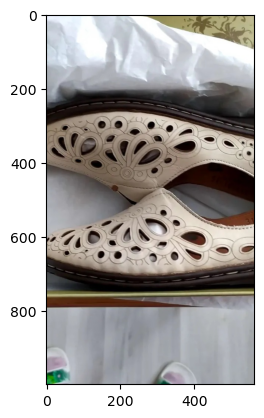

Corresponding product image:


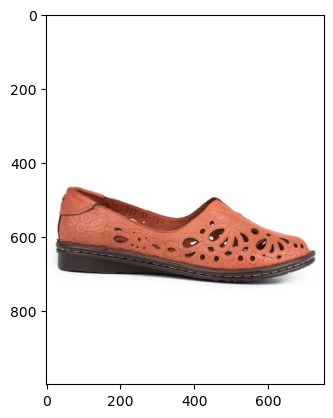

In [52]:
selected = 15
x = X_test[:, sorted_indices[selected]]  # sample
y = y_test[sorted_indices[selected]]
pred = y_pred[sorted_indices[selected]]
id = id_map[y]  # product id
name = test_names[sorted_indices[selected]]  # image name
sci = scis[sorted_indices[selected]]
w = w_cache[sorted_indices[selected]]
residuals = residuals_cache[sorted_indices[selected]]
print(f"#{id} {name}: SCI={sci:.3f}, predicted={pred}, label={y}")

# display test image
import cv2
print("User image:")
path = [f for f in os.listdir(os.path.join(DATASET_ROOT, "queries")) if f.startswith(name)][0]
im = Image.open(os.path.join(DATASET_ROOT, "queries", path)).convert('RGB')
plt.imshow(im)
plt.show()

# display train images
print("Corresponding product image:")
names = set([f[7:-4] for f in os.listdir(os.path.join(FEAT_OUTPUT_FOLDER, 'train')) if f.startswith(f"{id:04d}")])
paths = [f for f in os.listdir(os.path.join(DATASET_ROOT, "gallery")) if os.path.splitext(f)[0] in names]
ims = [Image.open(os.path.join(DATASET_ROOT, "gallery", f)).convert('RGB') for f in paths]
for im in ims:
    plt.imshow(im)
    plt.show()

### Coefficients

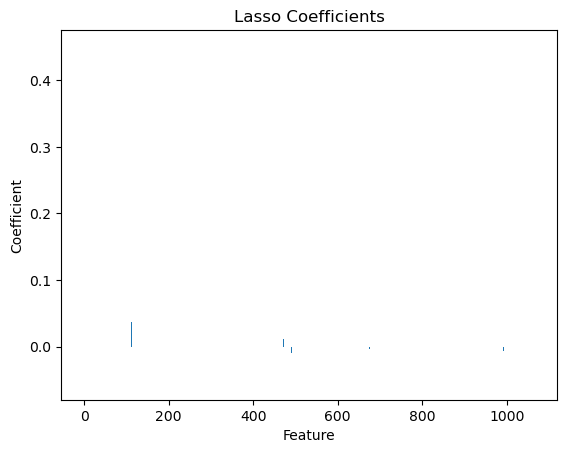

In [53]:
import matplotlib.pyplot as plt

plt.bar(range(len(w)), w)
plt.title("Lasso Coefficients")
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.show()

### Residuals

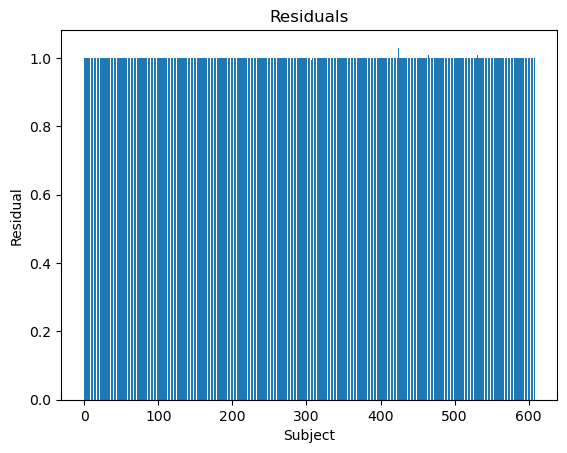

In [54]:
plt.bar(range(len(residuals)), residuals)
plt.title("Residuals")
plt.xlabel("Subject")
plt.ylabel("Residual")
plt.show()